In [1]:
# Import modules
import pandas as pd
import numpy as np
from datetime import datetime
import statsmodels.api as sm
import statsmodels.formula.api as smf # load the econometrics package
from scipy.stats import ttest_1samp
import warnings
warnings.simplefilter(action='ignore')
from statsmodels.regression.rolling import RollingOLS
import matplotlib.pyplot as plt

In [2]:
#Import our data
SP500 = pd.read_csv('SP500.csv',header=None)
SP500.columns = ['Date','ret_sp500','rf']# Specify the names of the columns
SP500 = SP500.drop(0,axis=0) #drop first row
SP500[['ret_sp500','rf']] =  SP500[['ret_sp500','rf']].astype(float) #convert values to floats
SP500['Date'] =  SP500['Date'].astype(str) #convert dates to strings

Data = pd.read_csv('Data.csv',header=None)
Data.rename(columns=Data.iloc[0], inplace=True)
Data = Data.drop(0,axis=0) 
Data['gvkey'] = Data['gvkey'].astype(str)
Data['date']=Data['date'].astype('int') #convert dates to integers to sort according to value
mask = (Data["date"] >=19700131) & (Data["date"] <= 20191231) #create mask to select specific dates within our dataframe
Data = Data.loc[mask]

CapitalIQ = pd.read_csv('CapitalIQ.csv',header=None)
CapitalIQ.rename(columns=CapitalIQ.iloc[0], inplace=True)
CapitalIQ = CapitalIQ.drop(0,axis=0) 

In [3]:
Data['date'] = Data['date'].astype(str)
Data['date'] = Data['date'].apply(lambda x: x[0:6]) #standardize "date" to monthly format

CapitalIQ['Date'] = CapitalIQ['Date'].astype(str)
CapitalIQ['Date'] = CapitalIQ['Date'].apply(lambda x: x[0:6])

In [4]:
#create a dataframe that tells us which companies are in S&P500 for each period
sp_members = pd.DataFrame(columns = Data['gvkey'].unique(), index = Data['date'].unique())
sp_members.sort_index(axis=0,inplace=True) #sort dates 

for i in sp_members.columns:
    x = Data[['sp500','date']].loc[Data['gvkey'] == i] #loc all gvkeys with sp500==1
    x = x.set_index(x['date']) #use the corresponding date as our index 
    for j in x.index:
        sp_members[i][j] = x['sp500'][j] #match each date with sp500 key
        
sp_members = sp_members.fillna(0)
sp_members = sp_members.astype(int)
sp_members.replace(to_replace=0, value= np.nan,inplace=True)

In [5]:
def var_mat(var_name):
    df_var = pd.DataFrame(columns = Data['gvkey'].unique(), index = Data['date'].unique())
    df_var.sort_index(axis=0,inplace=True)
    for i in df_var.columns:
        var_data = Data[[var_name,'date']].loc[Data['gvkey']==i]
        var_data = var_data.set_index(var_data['date'])
        df_var[i]=var_data[var_name]
    df_var = df_var.astype(float)
    df_var = df_var.multiply(sp_members)
    for i in df_var.columns:
        if df_var[i].isnull().all()==True:
            df_var.drop(i,axis=1,inplace=True)
    return df_var

In [6]:
#extract the monthly return matrix to facilitate calculation of factor returns
trt1m_mat = var_mat('trt1m')
trt1m_mat = trt1m_mat / 100 #Convert the monthly returns from percentage to actual values
trt1m_mat_T = trt1m_mat.T

In [8]:
#create a function that takes the factor data for each company as input, and outputs a dataframe containing top and bottom portfolio returns, along with the factor returns
def factor_return(var_mat):
    var_mat_T = var_mat.T
    factor_matrix = pd.DataFrame(columns=['Top', 'Bottom','QSpread'],index=var_mat.index)
    for i in var_mat_T.columns:
        companies = var_mat_T[i].sort_values(ascending =False).dropna()
        num = len(companies)
        binsize = round(num/5)
        top_companies = companies[:binsize].index
        bottom_companies = companies[-binsize:].index
        top_average_return = trt1m_mat_T[i][top_companies].mean()
        bottom_average_return = trt1m_mat_T[i][bottom_companies].mean()
        factor_matrix['Top'][i]=top_average_return
        factor_matrix['Bottom'][i]=bottom_average_return
        factor_matrix['QSpread'] = factor_matrix['Top']-factor_matrix['Bottom']
    return factor_matrix

In [9]:
def turnover(var_mat):
    var_mat_T=var_mat.T
    turnover_matrix = pd.DataFrame(columns=['Companies','Turnover','Ratio'],index=var_mat.index)
    for i in var_mat_T.columns:
        companies=var_mat_T[i].sort_values().dropna()
        num = len(companies)
        binsize = round(num/5)
        top_companies = companies[:binsize].index
        bottom_companies = companies[-binsize:].index
        total_companies=top_companies.append(bottom_companies)
        turnover_matrix.at[i,'Companies']=total_companies.tolist()
    for i in range(1,600):
        companies_last = turnover_matrix['Companies'].iloc[i-1]
        companies_now = turnover_matrix['Companies'].iloc[i]
        turnover_count=0
        for j in companies_last:
            if j not in companies_now:
                turnover_count=turnover_count+1
            else:
                turnover_count=turnover_count
        turnover_matrix['Turnover'].iloc[i]=turnover_count
        if len(companies_last) != 0:
            turnover_matrix['Ratio'].iloc[i]=turnover_count/len(companies_last)
        else:
            turnover_matrix['Ratio'].iloc[i]=np.nan
    return turnover_matrix

### Factor 1: Price Momentum

In [10]:
prccm_mat = var_mat('prccm')
HighM_mat=var_mat('prchm')
LowM_mat=var_mat('prclm')

In [11]:
CloseM = prccm_mat
HighM = HighM_mat
LowM = LowM_mat

In [12]:
HL1M=(HighM-CloseM)/(CloseM-LowM)

HL1M.replace([np.inf,-np.inf],np.nan,inplace=True)
HL1M=HL1M.shift().iloc[1:]

In [14]:
HL1M

,001010,001013,001040,001043,001045,001062,001075,001078,001098,001133,...,188255,189491,198058,199356,260774,260778,265975,266101,294524,316056
197002,14.000000,NaN,15.000000,NaN,NaN,2.411765,NaN,NaN,10.0,25.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,1.000000,7.666667,NaN,NaN
197003,0.066667,NaN,0.111111,5.538462,0.028169,0.000000,NaN,0.333333,1.8,0.888889,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.037037,NaN,NaN
197004,0.571429,NaN,0.090909,0.354839,2.181818,0.081967,NaN,0.833333,10.0,9.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,1.181818,NaN,NaN,NaN
197005,2.000000,NaN,1.461538,3.714286,3.555556,1.217391,NaN,2.350000,1.0,7.666667,...,NaN,NaN,NaN,NaN,NaN,NaN,9.500000,NaN,NaN,NaN
197006,2.304348,NaN,0.285714,2.727273,0.317073,15.250000,NaN,1.333333,11.0,0.368421,...,NaN,NaN,NaN,NaN,NaN,NaN,3.000000,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
201908,NaN,NaN,NaN,NaN,NaN,NaN,7.579710,0.395238,NaN,NaN,...,1.273810,7.500000,1.124324,11.274194,0.419753,0.767137,NaN,NaN,5.011325,1.594340
201909,NaN,NaN,NaN,NaN,NaN,NaN,0.099332,0.691919,NaN,NaN,...,2.359223,1.377301,9.780105,3.158915,1.284404,2.345382,NaN,NaN,0.816990,2.514970
201910,NaN,NaN,NaN,NaN,NaN,NaN,0.256367,1.041509,NaN,NaN,...,0.055821,0.153430,0.066961,2.181892,1.717033,17.200000,NaN,NaN,0.067992,0.117581
201911,NaN,NaN,NaN,NaN,NaN,NaN,1.650485,0.227451,NaN,NaN,...,0.254038,2.349476,0.639535,0.103343,0.139875,0.105750,NaN,NaN,0.301685,0.062925


In [15]:
trt1m_mat

,001010,001013,001040,001043,001045,001062,001075,001078,001098,001133,...,188255,189491,198058,199356,260774,260778,265975,266101,294524,316056
197001,-0.053571,NaN,-0.047297,-0.180328,-0.227642,0.086364,NaN,-0.042157,-0.065217,-0.060000,...,NaN,NaN,NaN,NaN,NaN,NaN,0.028571,-0.012500,NaN,NaN
197002,0.050674,NaN,0.204255,-0.108000,0.266316,0.108787,NaN,0.035959,-0.024419,0.010638,...,NaN,NaN,NaN,NaN,NaN,NaN,-0.013889,0.091525,NaN,NaN
197003,0.023377,NaN,0.023810,0.059322,-0.100418,0.249057,NaN,-0.031405,-0.024242,-0.052632,...,NaN,NaN,NaN,NaN,NaN,NaN,0.019643,NaN,NaN,NaN
197004,-0.076142,NaN,-0.075581,-0.264000,-0.111628,-0.069486,NaN,-0.054266,-0.043478,-0.244444,...,NaN,NaN,NaN,NaN,NaN,NaN,-0.068301,NaN,NaN,NaN
197005,-0.140660,NaN,-0.020126,-0.192754,0.018848,-0.013636,NaN,-0.097826,-0.098701,0.044118,...,NaN,NaN,NaN,NaN,NaN,NaN,-0.086466,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
201908,NaN,NaN,NaN,NaN,NaN,NaN,0.044837,-0.020436,NaN,NaN,...,-0.066618,-0.042845,-0.258781,-0.139524,-0.013960,-0.057476,NaN,NaN,-0.075397,-0.070214
201909,NaN,NaN,NaN,NaN,NaN,NaN,0.018466,-0.019339,NaN,NaN,...,0.071289,0.039290,0.257013,0.018163,0.014157,-0.042735,NaN,NaN,0.169811,0.079464
201910,NaN,NaN,NaN,NaN,NaN,NaN,-0.030390,0.003107,NaN,NaN,...,0.097806,-0.033785,-0.063028,0.044467,0.010187,0.144423,NaN,NaN,0.002571,0.119537
201911,NaN,NaN,NaN,NaN,NaN,NaN,-0.063191,0.022007,NaN,NaN,...,0.057119,0.010692,0.195365,-0.210396,0.064799,0.085873,NaN,NaN,0.043367,0.034385


In [13]:
HL1M_factor=factor_return(HL1M) #dataframe containing top and bottom portfolio returns, along with the QSpread
HL1M_qspread = HL1M_factor['QSpread']['198701':]
HL1M_factor

,Top,Bottom,QSpread
197002,0.0865511,0.0440043,0.0425467
197003,0.0184946,0.00709207,0.0114025
197004,-0.11203,-0.110255,-0.00177511
197005,-0.0715759,-0.0643745,-0.0072014
197006,-0.0393391,-0.0669943,0.0276553
...,...,...,...
201908,-0.0226275,-0.0437093,0.0210818
201909,0.0626453,0.00938943,0.0532559
201910,0.0181276,0.00920145,0.00892612
201911,0.0260924,0.0396021,-0.0135096


In [63]:
x1=CapitalIQ.loc[113:]['HL1M'].astype(float).tolist()
y1=HL1M_factor.loc['199605':]['QSpread'].tolist()
np.corrcoef(x1,y1)

array([[1.        , 0.99105639],
       [0.99105639, 1.        ]])

### Factor 2:  Expected LTG

In [13]:
LTG_mat = var_mat('LTG')

In [64]:
LTG_factor = factor_return(LTG_mat)
LTG_qspread = LTG_factor['QSpread']['199605':]
LTG_factor

,Top,Bottom,QSpread
197001,NaN,NaN,NaN
197002,NaN,NaN,NaN
197003,NaN,NaN,NaN
197004,NaN,NaN,NaN
197005,NaN,NaN,NaN
...,...,...,...
201908,-0.0399315,-0.061625,0.0216935
201909,0.00208154,0.0547304,-0.0526489
201910,0.0193263,0.00587226,0.0134541
201911,0.039952,0.0413704,-0.00141839


In [65]:
# Check correlation with benchmark
x2=CapitalIQ.loc[113:]['LTGC'].astype(float).tolist()
y2=LTG_factor.loc['199605':]['QSpread'].tolist()
np.corrcoef(x2,y2)

array([[1.        , 0.92198374],
       [0.92198374, 1.        ]])

### Factor 3: Long-Term Momentum

In [66]:
MOM=trt1m_mat.rolling(11,min_periods=11).mean()
MOM=MOM.shift(2)

MOM_factor=factor_return(MOM) #dataframe containing top and bottom portfolio returns, along with the factor returns
MOM_qspread = MOM_factor['QSpread']['198701':]

In [67]:
MOM_factor

,Top,Bottom,QSpread
197001,NaN,NaN,NaN
197002,NaN,NaN,NaN
197003,NaN,NaN,NaN
197004,NaN,NaN,NaN
197005,NaN,NaN,NaN
...,...,...,...
201908,0.00836467,-0.0948715,0.103236
201909,-0.00471122,0.06988,-0.0745912
201910,-0.00424432,0.0201405,-0.0243849
201911,0.017994,0.0538897,-0.0358958


In [68]:
x3=CapitalIQ['MOM'].astype(float).tolist() 
y3=MOM_factor.loc['198701':]['QSpread'].tolist() 
np.corrcoef(x3,y3)

array([[1.        , 0.92899776],
       [0.92899776, 1.        ]])

### Factor 4: Book to Market

In [19]:
ceqq_mat=var_mat('ceqq')
cshoq_mat=var_mat('cshoq')

In [69]:
CEQQ=ceqq_mat
CSHOQ=cshoq_mat
CloseM=prccm_mat
BTP=(CEQQ)/(CSHOQ*CloseM)
BTP.replace([np.inf,-np.inf],np.nan,inplace=True)
BTP=BTP.shift().iloc[1:]

BTP_factor=factor_return(BTP) #dataframe containing top and bottom portfolio returns, along with the factor returns
BTP_qspread = BTP_factor['QSpread']['198701':]
BTP_factor

,Top,Bottom,QSpread
197002,0.0783502,0.0585229,0.0198273
197003,0.00536025,-0.0185914,0.0239516
197004,-0.10981,-0.109483,-0.000327116
197005,-0.0962584,-0.107922,0.0116634
197006,-0.0420387,-0.0448507,0.002812
...,...,...,...
201908,-0.0715621,-0.00734223,-0.0642198
201909,0.0663038,0.00174569,0.0645581
201910,0.00067384,0.0215005,-0.0208267
201911,0.0351836,0.0379828,-0.00279918


In [70]:
x4=CapitalIQ['BP'].astype(float).tolist()
y4=BTP_factor.loc['198701':]['QSpread'].tolist()
np.corrcoef(x4,y4)

array([[1.        , 0.98862778],
       [0.98862778, 1.        ]])

### Factor 5: CAPM Beta

In [22]:
#organize the sp500 dataframe to facilitate calculation
market_RP = SP500['ret_sp500']-SP500['rf']
SP500['market_RP']=market_RP
SP500.set_index(SP500['Date'],inplace=True)

In [23]:
#Calculate the company risk premiums by subtracting the risk free rate from the trt1m matrix
risk_premium = trt1m_mat
for i in trt1m_mat.columns:
    risk_premium[i] = trt1m_mat[i] - np.asarray(SP500['rf'])

In [24]:
#create a dataframe to store all the betas extracted 
betas = pd.DataFrame(columns = risk_premium.columns, index = Data['date'].unique())
betas.sort_index(axis=0,inplace=True)

In [25]:
#We now loop through all companies to obtain the betas matrix
for i in risk_premium.columns:
    Y=risk_premium[i]
    X=SP500['market_RP']
    X=sm.add_constant(X)
    reg=RollingOLS(Y,X,window=48)
    regfit= reg.fit()
    params = regfit.params
    betas[i] = params['market_RP']

In [26]:
Betas_factor=factor_return(betas) #dataframe containing top and bottom portfolio returns, along with the factor returns
Betas_qspread = Betas_factor['QSpread']['198701':]

In [27]:
Betas_factor

,Top,Bottom,QSpread
197001,NaN,NaN,NaN
197002,NaN,NaN,NaN
197003,NaN,NaN,NaN
197004,NaN,NaN,NaN
197005,NaN,NaN,NaN
...,...,...,...
201908,0.0394068,-0.0870795,0.126486
201909,0.00842476,0.065916,-0.0574912
201910,-0.0119027,0.0265129,-0.0384156
201911,-0.00864116,0.0583786,-0.0670197


In [28]:
x5=CapitalIQ['Beta'].astype(float).tolist()
y5=Betas_factor.loc['198701':]['QSpread'].tolist()
np.corrcoef(x5,y5)

array([[ 1.       , -0.9252044],
       [-0.9252044,  1.       ]])

### Factor 6: LogMCap

In [29]:
cshom_mat = var_mat('cshom')
CSHOM=cshom_mat
LogMktCap=np.log(CSHOM*CloseM)

In [71]:
LogMktCap_factor=factor_return(LogMktCap) #dataframe containing top and bottom portfolio returns, along with the factor returns
LogMktCap_qspread = LogMktCap_factor.loc['199804':]['QSpread']
LogMktCap_factor

,Top,Bottom,QSpread
197001,NaN,NaN,NaN
197002,NaN,NaN,NaN
197003,NaN,NaN,NaN
197004,NaN,NaN,NaN
197005,NaN,NaN,NaN
...,...,...,...
201908,0.00108518,-0.0988939,0.099979
201909,0.00964877,0.0712406,-0.0615918
201910,0.0245238,0.00396662,0.0205572
201911,0.0393572,0.0214235,0.0179338


In [72]:
x6=CapitalIQ.loc[136:]['LogMktCap'].astype(float).tolist()
y6=LogMktCap_factor.loc['199804':]['QSpread'].tolist()
np.corrcoef(x6,y6)

array([[ 1.        , -0.92932585],
       [-0.92932585,  1.        ]])

### **Factor 7: Volatility**

In [73]:
rit = np.log(CloseM/CloseM.shift())
AnnVol = ((rit ** 2).rolling(11,min_periods=11).mean())**0.5 * (12**0.5)

In [74]:
AnnVol_factor = factor_return(AnnVol)
AnnVol_qspread = AnnVol_factor.loc['198701':]['QSpread']
AnnVol_factor

,Top,Bottom,QSpread
197001,NaN,NaN,NaN
197002,NaN,NaN,NaN
197003,NaN,NaN,NaN
197004,NaN,NaN,NaN
197005,NaN,NaN,NaN
...,...,...,...
201908,-0.105295,0.0283613,-0.133656
201909,0.0691007,0.0175714,0.0515294
201910,0.0227788,-0.00313555,0.0259144
201911,0.0477411,0.00655232,0.0411887


In [75]:
x7=CapitalIQ['AnnVol12M'].astype(float).tolist() 
y7=AnnVol_factor.loc['198701':]['QSpread'].tolist()
np.corrcoef(x7,y7)

array([[1.        , 0.94608073],
       [0.94608073, 1.        ]])

**We export all factor matrices to an excel file**

In [35]:
#export data to excel
with pd.ExcelWriter('Factor_SP500.xlsx') as writer:
    HL1M.to_excel(writer,sheet_name='HL1M')
    LTG_mat.to_excel(writer,sheet_name='LTG')
    MOM.to_excel(writer,sheet_name='MOM')
    BTP.to_excel(writer,sheet_name='BTP')
    betas.to_excel(writer,sheet_name='Beta')
    LogMktCap.to_excel(writer,sheet_name='LogMktCap')
    AnnVol.to_excel(writer,sheet_name='AnnVol')

### **Question 1**

In [56]:
BTP_factor['Date']=BTP_factor.index
def mergedate(x):
    return datetime.strptime(x, "%Y%m")
sp_members['Date']=sp_members.index
def mergedate(x):
    return datetime.strptime(x, "%Y%m")

BTP_factor['TS']=BTP_factor['Date'].map(mergedate)
sp_members['TS']=sp_members['Date'].map(mergedate)
SP500['TS']=SP500['Date'].map(mergedate)
CapitalIQ['TS']=CapitalIQ['Date'].map(mergedate)

**Time Series of Number of Firms**

In [57]:
sp_count=sp_members.sum(axis=1)

Text(0, 0.5, 'Number of Firms')

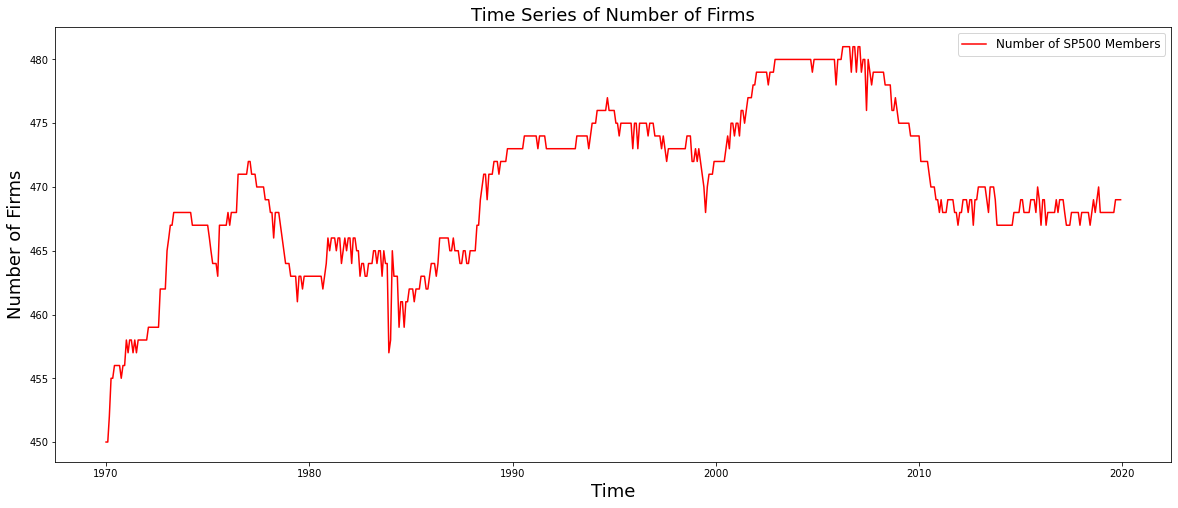

In [58]:
plt.figure(figsize=(20,8))
plt.plot(sp_members['TS'],sp_count,label='Number of SP500 Members',c='r',lw=1.5,ls='-')
plt.title('Time Series of Number of Firms', fontsize=18)
plt.legend(loc='best',fontsize=12)
plt.xlabel('Time', fontsize=18)
plt.ylabel('Number of Firms', fontsize=18)

**BP QSpread vs CapitalIQ**

Text(0, 0.5, 'Return')

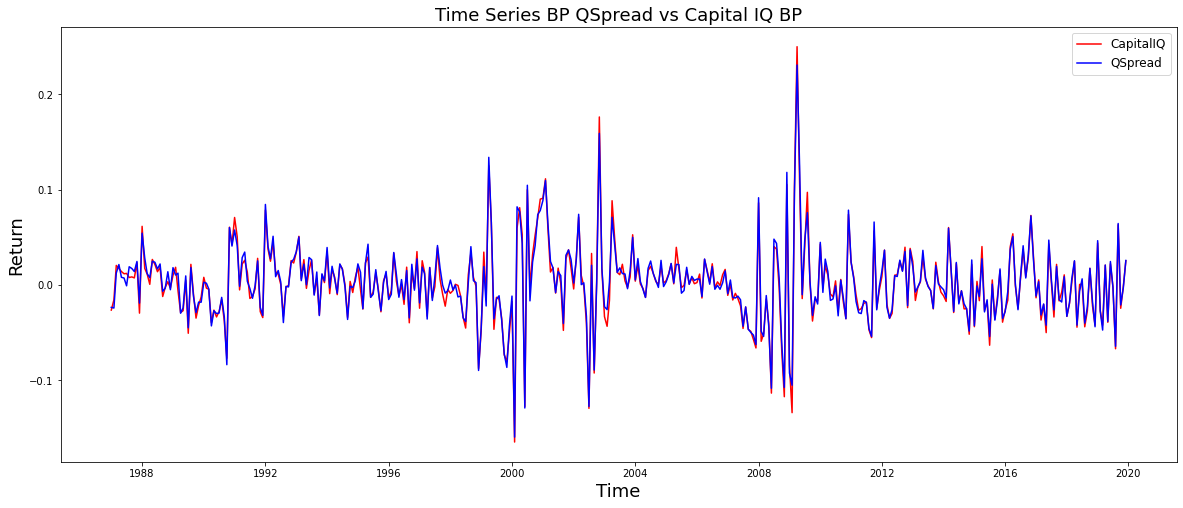

In [59]:
plt.figure(figsize=(20,8)) 
plt.plot(CapitalIQ['TS'],CapitalIQ['BP'].astype(float), label='CapitalIQ',c='r',lw=1.5,ls='-')
plt.plot(BTP_factor.loc['1987':]['TS'],BTP_factor.loc['1987':]['QSpread'], label='QSpread',c='b',lw=1.5,ls='-')
plt.title('Time Series BP QSpread vs Capital IQ BP', fontsize=18)
plt.legend(loc='best',fontsize=12)
plt.xlabel('Time', fontsize=18)
plt.ylabel('Return', fontsize=18)

**Long-Leg & Short-Leg Returns**

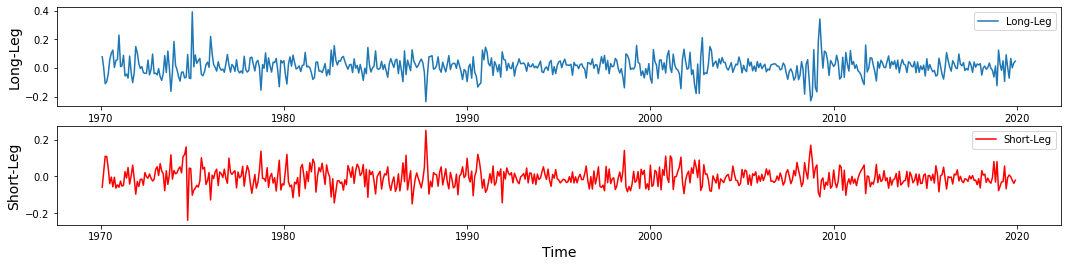

In [60]:
# Two subplots figure with 2 seperate graphs
plt.figure(figsize=(18,4))
plt.subplot(211) # 1 row 2 columns graph #1. 
plt.plot(BTP_factor["TS"],BTP_factor["Top"], label="Long-Leg") #plot long-leg against time series
plt.xlabel('Time', fontsize=14)
plt.ylabel('Long-Leg', fontsize=14)
plt.legend(loc='best')

plt.subplot(212) # 1 row 2 columns graph #2  
plt.plot(BTP_factor["TS"],BTP_factor["Bottom"]*(-1), label="Short-Leg",c='r') #plot short-leg against time series
plt.xlabel('Time', fontsize=14)
plt.ylabel('Short-Leg', fontsize=14)
plt.legend(loc='best') 

**Cumulative Returns of BP QSpread & SP500**

Text(0, 0.5, 'Return')

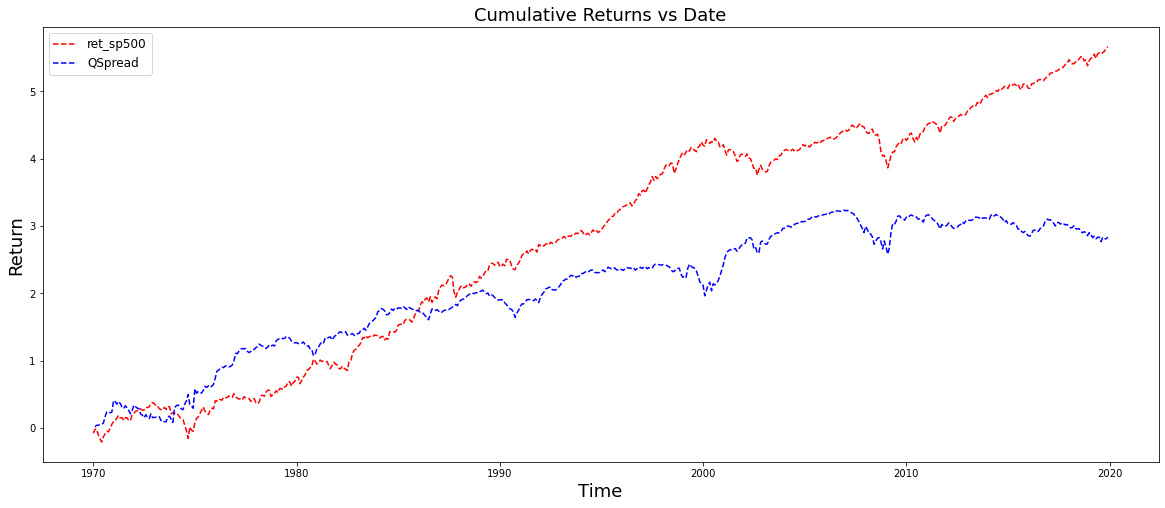

In [61]:
plt.figure(figsize=(20,8)) 
plt.plot(SP500['TS'],SP500['ret_sp500'].cumsum(), label='ret_sp500',c='r',lw=1.5,ls='--')
plt.plot(BTP_factor['TS'],BTP_factor['QSpread'].cumsum(), label='QSpread',c='b',lw=1.5,ls='--')
plt.title('Cumulative Returns vs Date', fontsize=18)
plt.legend(loc='best',fontsize=12)
plt.xlabel('Time', fontsize=18)
plt.ylabel('Return', fontsize=18)

**Comment:**

Looking at the second graph, factor BP's return is quite comparable to S&P500 return for most of the time, however it moves slightly less extreme when markets are volatile (ex. 2002, 2009). 
- Judging from the third plot (long vs short), the long leg and short leg are moving in opposite directions; however, the change in the short leg is generally greater than the change in the long leg, so the short leg contributes more to the factor performance
- The book to price factor return tends to move with the market, so the performance is bad when the market is down (recession), and vice versa. 

### **Question 2**

In [76]:
#create correlation matrix 
q2table = pd.DataFrame(columns=['Name','Correlation'],index=['HL1M','LTG','MOM','BP','Beta','Size','Vol12M'])
q2table['Name']=['1M Price High - 1M Price Low', 'Expected LTG', 'Long-term Momentum',
                'Book to Price','CAPM Beta','Log Market Cap','12M Realized Price Volatility']

In [77]:
# input correlation data
q2table['Correlation']['HL1M']=abs(np.corrcoef(x1,y1)[0][1])
q2table['Correlation']['LTG']=abs(np.corrcoef(x2,y2)[0][1])
q2table['Correlation']['MOM']=abs(np.corrcoef(x3,y3)[0][1])
q2table['Correlation']['BP']=abs(np.corrcoef(x4,y4)[0][1])
q2table['Correlation']['Beta']=abs(np.corrcoef(x5,y5)[0][1])
q2table['Correlation']['Size']=abs(np.corrcoef(x6,y6)[0][1])
q2table['Correlation']['Vol12M']=abs(np.corrcoef(x7,y7)[0][1])

In [78]:
q2table

,Name,Correlation
HL1M,1M Price High - 1M Price Low,0.991056
LTG,Expected LTG,0.921984
MOM,Long-term Momentum,0.928998
BP,Book to Price,0.988628
Beta,CAPM Beta,0.925204
Size,Log Market Cap,0.929326
Vol12M,12M Realized Price Volatility,0.946081


### **Question 3**

In [79]:
#Create a matrix consisting only factor returns (qspread) and the SP500 return
qspread_mat = pd.DataFrame(columns=['HL1M', 'LTG','MOM','BP','Beta','Size', 'Vol12M','SP500'],index=sp_members.index)
qspread_mat['HL1M']=HL1M_factor['QSpread']
qspread_mat['LTG']=LTG_factor['QSpread']
qspread_mat['MOM']=MOM_factor['QSpread']
qspread_mat['BP']=BTP_factor['QSpread']
qspread_mat['Beta']=Betas_factor['QSpread']
qspread_mat['Size']=LogMktCap_factor['QSpread']
qspread_mat['Vol12M']=AnnVol_factor['QSpread']
qspread_mat['SP500']=SP500['ret_sp500']
qspread_mat=qspread_mat.astype(float)
qspread_mat.head(5)

,HL1M,LTG,MOM,BP,Beta,Size,Vol12M,SP500
197001,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.075398
197002,0.042547,NaN,NaN,0.019827,NaN,NaN,NaN,0.059521
197003,0.011403,NaN,NaN,0.023952,NaN,NaN,NaN,0.002806
197004,-0.001775,NaN,NaN,-0.000327,NaN,NaN,NaN,-0.088831
197005,-0.007201,NaN,NaN,0.011663,NaN,NaN,NaN,-0.054689


In [80]:
#Create a matrix consisting of the portfolio turnover details (the percentage portfolio turnovers for each period) for each factor
turnover_rates = pd.DataFrame(columns=['HL1M', 'LTG','MOM','BP','Beta','Size', 'Vol12M','SP500'],index=sp_members.index)
nullrow=pd.DataFrame(columns=HL1M.columns,index=['197001'])
turnover_rates['HL1M']=turnover(pd.concat([nullrow,HL1M]))['Ratio']
turnover_rates['LTG']=turnover(LTG_mat)['Ratio']
turnover_rates['MOM']=turnover(MOM)['Ratio']
turnover_rates['BP']=turnover(pd.concat([nullrow,BTP]))['Ratio']
turnover_rates['Beta']=turnover(betas)['Ratio']
turnover_rates['Size']=turnover(LogMktCap)['Ratio']
turnover_rates['Vol12M']=turnover(AnnVol)['Ratio']
turnover_rates.head(5)

,HL1M,LTG,MOM,BP,Beta,Size,Vol12M,SP500
197001,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
197002,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
197003,0.690141,NaN,NaN,0.12069,NaN,NaN,NaN,NaN
197004,0.5625,NaN,NaN,0.0775862,NaN,NaN,NaN,NaN
197005,0.646067,NaN,NaN,0.939655,NaN,NaN,NaN,NaN


In [91]:
#Output the results in the required table format
q3table=pd.DataFrame(columns=['HL1M', 'LTG','MOM','BP','Beta','Size', 'Vol12M','SP500'],
                     index=['Mean','STD','Sharpe Ratio','Skewness','Kurtosis','Max','Min','Max Drawdown',
                           'Average turnover','ACF1','ACF12','ACF24'])
for i in q3table.columns:
    q3table[i]['Mean']=qspread_mat[i].mean() * 100
    q3table[i]['STD']=qspread_mat[i].std() * 100
    q3table[i]['Sharpe Ratio']=((qspread_mat[i] - SP500['rf'])/q3table[i]['STD']).mean() * 100
    q3table[i]['Skewness']=qspread_mat[i].skew()
    q3table[i]['Kurtosis']=qspread_mat[i].kurtosis()
    q3table[i]['Max']=qspread_mat[i].max() * 100
    q3table[i]['Min']=qspread_mat[i].min()  * 100
    q3table[i]['Max Drawdown']=(qspread_mat[i].max()-qspread_mat[i].min())/qspread_mat[i].max()
    q3table[i]['Average turnover']=turnover_rates[i].mean() * 100
    q3table[i]['ACF1']=qspread_mat[i].autocorr(lag=1)
    q3table[i]['ACF12']=qspread_mat[i].autocorr(lag=12)
    q3table[i]['ACF24']=qspread_mat[i].autocorr(lag=24)
q3table

,HL1M,LTG,MOM,BP,Beta,Size,Vol12M,SP500
Mean,0.980369,0.11763,0.370697,0.473495,-0.235369,1.40845,0.502637,0.94386
STD,3.4237,4.44262,5.13644,4.17962,8.08794,4.03841,6.49719,4.34335
Sharpe Ratio,0.175766,-0.0371345,-0.00101975,0.0227049,-0.0753604,0.310388,0.0194894,0.130059
Skewness,1.37201,0.277284,-1.57761,1.08324,-0.346195,0.0732787,0.417203,-0.450438
Kurtosis,6.9395,4.31183,9.74704,7.06389,4.53109,3.64249,3.85064,1.92018
Max,23.2693,23.3535,15.4887,28.901,35.7767,15.8801,40.2329,16.8113
Min,-10.7999,-19.5047,-39.3526,-15.9404,-49.1467,-18.4471,-23.616,-21.5795
Max Drawdown,1.46413,1.83519,3.54074,1.55155,2.37371,2.16164,1.58698,2.28363
Average turnover,60.6967,8.55963,24.3585,9.25289,7.71933,4.50314,12.5522,NaN
ACF1,-0.082081,0.017655,0.0658412,0.0957443,0.0660726,0.189731,0.0988807,0.0229084


In [82]:
#Create the correlation table
corr_table=qspread_mat.corr()
corr_table

,HL1M,LTG,MOM,BP,Beta,Size,Vol12M,SP500
HL1M,1.000000,0.228280,-0.499336,0.438722,-0.432594,-0.386406,0.487352,0.309532
LTG,0.228280,1.000000,0.022976,-0.346426,-0.583239,0.069024,0.539024,0.423991
MOM,-0.499336,0.022976,1.000000,-0.652437,0.357265,0.632582,-0.394255,-0.174367
BP,0.438722,-0.346426,-0.652437,1.000000,-0.232942,-0.758533,0.360145,0.123070
Beta,-0.432594,-0.583239,0.357265,-0.232942,1.000000,0.513606,-0.921778,-0.819050
Size,-0.386406,0.069024,0.632582,-0.758533,0.513606,1.000000,-0.620004,-0.446456
Vol12M,0.487352,0.539024,-0.394255,0.360145,-0.921778,-0.620004,1.000000,0.764253
SP500,0.309532,0.423991,-0.174367,0.123070,-0.819050,-0.446456,0.764253,1.000000


### **Question 4:**

In [83]:
q4table = pd.DataFrame(columns=['Name','Average Spread','t statistics','p-value'],index=['HL1M','LTG','MOM','BP','Beta','Size','Vol12M'])
q4table['Name']=['1M Price High - 1M Price Low', 'Expected LTG', 'Long-term Momentum',
                'Book to Price','CAPM Beta','Log Market Cap','12M Realized Price Volatility']

In [84]:
# Input the average qspread we calculated previously

q4table['Average Spread']['HL1M']=HL1M_qspread.mean()
q4table['Average Spread']['LTG']=LTG_qspread.mean()
q4table['Average Spread']['MOM']=MOM_qspread.mean()
q4table['Average Spread']['BP']=BTP_qspread.mean()
q4table['Average Spread']['Beta']=Betas_qspread.mean()
q4table['Average Spread']['Size']=LogMktCap_qspread.mean()
q4table['Average Spread']['Vol12M']=AnnVol_qspread.mean()

In [85]:
#Perform t-test to each of the factor average spreads, and collect the values
t_stat = []
p_value=[]
for i in [HL1M_qspread,LTG_qspread,MOM_qspread,BTP_qspread,
          Betas_qspread,LogMktCap_qspread,AnnVol_qspread]:
    t_stat.append(ttest_1samp(i,0)[0])
    p_value.append(ttest_1samp(i,0)[1])
    
print(t_stat)
print(p_value)

[4.7477351038853906, 0.7263990800697379, 0.8058340673007294, 1.3759568803857865, -0.6868685795354144, 5.634459382084201, 1.144047737507477]
[2.88179506692042e-06, 0.4681945204370539, 0.42082337907217715, 0.16961461000632339, 0.4925685889990341, 4.5573087168869404e-08, 0.2532966526253037]


In [86]:
q4table['t statistics'] = t_stat
q4table['p-value']=p_value

q4table

,Name,Average Spread,t statistics,p-value
HL1M,1M Price High - 1M Price Low,0.00849754,4.747735,2.881795e-06
LTG,Expected LTG,0.00215187,0.726399,4.681945e-01
MOM,Long-term Momentum,0.00221544,0.805834,4.208234e-01
BP,Book to Price,0.00271829,1.375957,1.696146e-01
Beta,CAPM Beta,-0.00296751,-0.686869,4.925686e-01
Size,Log Market Cap,0.0140845,5.634459,4.557309e-08
Vol12M,12M Realized Price Volatility,0.00391021,1.144048,2.532967e-01


**Comment:**

From the table above we can see that the expected LTG, long term momentum, book to price, CAPM Beta, 12 month realized price volatility all have factor returns with mean not so different than 0 (all of them have p-values > 0.2, so cannot reject null hypothesis). 

On the other hand, 1M high - 1M low, log market cap both have factor returns with mean statistically different than 0. 
- The results are consistent with our observations on the factor returns
    - These 2 factors both generally outperform the market 

### **Question 5:**

- We struggled with cleaning the data, extracting them into organized matrices. Initially, we tried appending everything into one large dataframe. This method, however, was very inefficient. Instead, we figured out a way to design a function that extracts all relevant data for any variable we feed it (var_mat). 
- Another difficulty that we faced is sorting the huge factor matrices, and then create portfolios for each time period according to existing sp500 companies (sp_members). We solved this issue by multiplying the aforementioned function with a matrix that takes a variable's value to zero if the respective company is not in the SP500 during that period of time.